# Analyzing Car Rental Data with Amazon Athena

This notebook demonstrates how to use Amazon Athena to query the processed car rental data that has been cataloged by AWS Glue.

In [2]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys

# Add the project root directory to the Python path
sys.path.append("..")

# Import project configuration
from config.aws_config import GLUE_CONFIG, S3_CONFIG, AWS_REGION

# Set plot style
plt.style.use("ggplot")
sns.set(style="whitegrid")

# Configure pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 1000)

## Set Up Athena Client

In [9]:
def run_athena_query(query: str, database: str, s3_output: str) -> pd.DataFrame:
    """
    Run a query on Athena and return the results as a pandas DataFrame.

    Args:
        query (str): The SQL query to run
        database (str): The Athena database to query
        s3_output (str): The S3 location to store query results

    Returns:
        DataFrame: The query results as a pandas DataFrame
    """
    athena_client = boto3.client("athena", region_name=AWS_REGION)
    s3_client = boto3.client("s3", region_name=AWS_REGION)

    # Start the query execution
    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={"Database": database},
        ResultConfiguration={"OutputLocation": s3_output},
    )

    query_execution_id = response["QueryExecutionId"]
    print(f"Query execution ID: {query_execution_id}")

    # Wait for the query to complete
    state = "RUNNING"
    while state in ["RUNNING", "QUEUED"]:
        response = athena_client.get_query_execution(
            QueryExecutionId=query_execution_id
        )
        state = response["QueryExecution"]["Status"]["State"]

        if state in ["RUNNING", "QUEUED"]:
            print(f"Query is {state}. Waiting...")
            time.sleep(5)

    # Check if the query succeeded
    if state == "SUCCEEDED":
        print("Query succeeded!")

        # Get the results
        result_file = f"{s3_output.rstrip('/')}/{query_execution_id}.csv"
        bucket_name = result_file.split("//")[1].split("/")[0]
        key = "/".join(result_file.split("//")[1].split("/")[1:])

        # Download the results
        local_file = "athena_query_result.csv"
        s3_client.download_file(bucket_name, key, local_file)

        # Load the results into a DataFrame
        df = pd.read_csv(local_file)

        # Clean up the local file
        os.remove(local_file)

        return df
    else:
        error_message = response["QueryExecution"]["Status"].get(
            "StateChangeReason", "Unknown error"
        )
        print(f"Query failed: {error_message}")
        return None


In [10]:
# Set up Athena query parameters
database_name = GLUE_CONFIG["database_name"]
s3_output = (
    f"s3://{S3_CONFIG['bucket_name']}/{S3_CONFIG['temp_data_prefix']}athena_results/"
)

print("Running Athena query to get total number of rentals by vehicle type...")
print("Database: ", database_name)
print("S3 Output: ", s3_output)


Running Athena query to get total number of rentals by vehicle type...
Database:  car_rental_db
S3 Output:  s3://emr-car-rental-data-lake/temp/athena_results/


## Query 1: Highest Revenue-Generating Locations

In [5]:
query1 = """
SELECT 
    location_id, 
    location_name, 
    city, 
    state, 
    total_revenue
FROM 
    location_metrics
ORDER BY 
    total_revenue DESC
LIMIT 10
"""

top_revenue_locations = run_athena_query(query1, database_name, s3_output)
top_revenue_locations

2025-04-16 11:42:15 - INFO - Found credentials in environment variables.


Query execution ID: 65165c35-676b-4745-a2d9-14f82b1a1103
Query is QUEUED. Waiting...
Query succeeded!


,location_id,location_name,city,state,total_revenue
0,1761,Collins LLC,Irvine,CA,148670.0
1,6363,Goodwin-Young,Oceanside,CA,141940.0
2,2268,"Gordon, Marshall and Snyder",Corona,CA,139510.0
3,7676,"Lee, Williams and Rocha",Hayward,CA,136110.0
4,4380,Bean LLC,Fontana,CA,135090.0
5,9536,Brown Ltd,Irvine,CA,134380.0
6,9853,Rogers-Joyce,Stockton,CA,134100.0
7,8573,Jefferson-Bryan,Elk Grove,CA,133590.0
8,4856,"Jones, Ponce and Mccall",Escondido,CA,132650.0
9,2363,Bonilla-James,Salinas,CA,132140.0


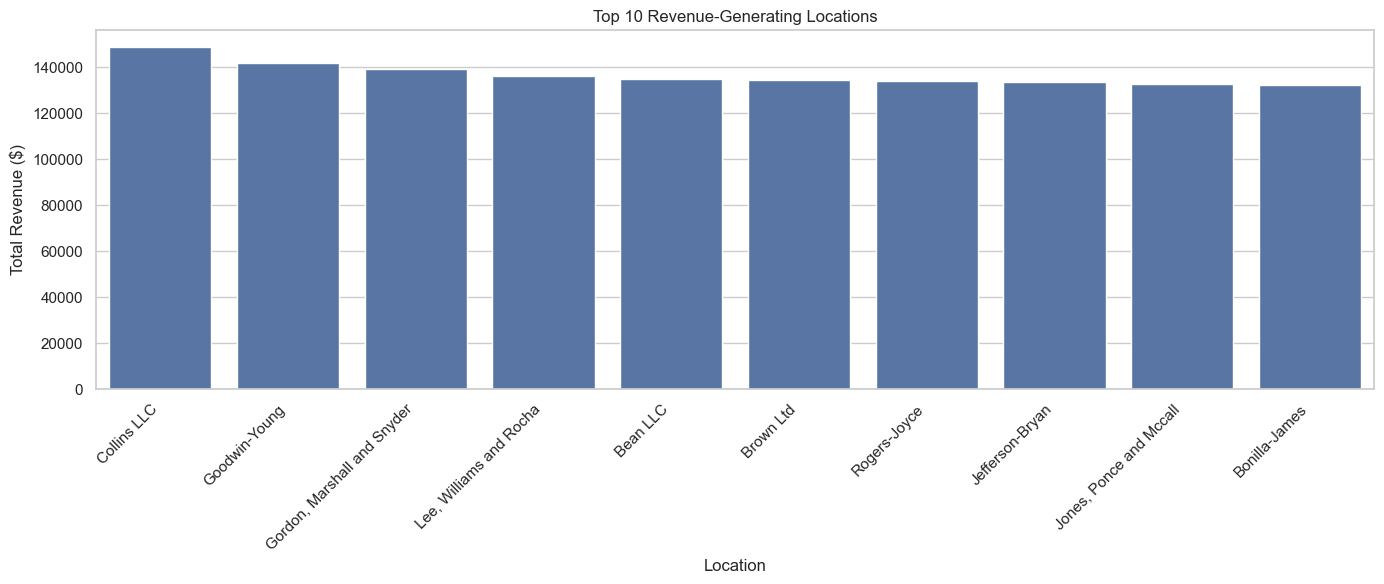

In [ ]:
# Visualize top revenue-generating locations
plt.figure(figsize=(14, 6))
sns.barplot(x="location_name", y="total_revenue", data=top_revenue_locations)
plt.title("Top 10 Revenue-Generating Locations")
plt.xlabel("Location")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Query 2: Most Rented Vehicle Types

In [11]:
query2 = """
SELECT 
    vehicle_type, 
    total_rentals, 
    total_revenue, 
    avg_rental_amount,
    avg_rental_duration_hours
FROM 
    vehicle_type_metrics
ORDER BY 
    total_rentals DESC
"""

vehicle_type_rentals = run_athena_query(query2, database_name, s3_output)
vehicle_type_rentals

Query execution ID: 9e911115-da14-4098-a2c3-4ecc944ed2a5
Query is QUEUED. Waiting...
Query succeeded!


,vehicle_type,total_rentals,total_revenue,avg_rental_amount,avg_rental_duration_hours
0,premium,8139,5899420.0,724.83,36.24
1,basic,7931,2902650.0,365.99,36.60
2,high_end,4010,7398550.0,1845.02,36.90


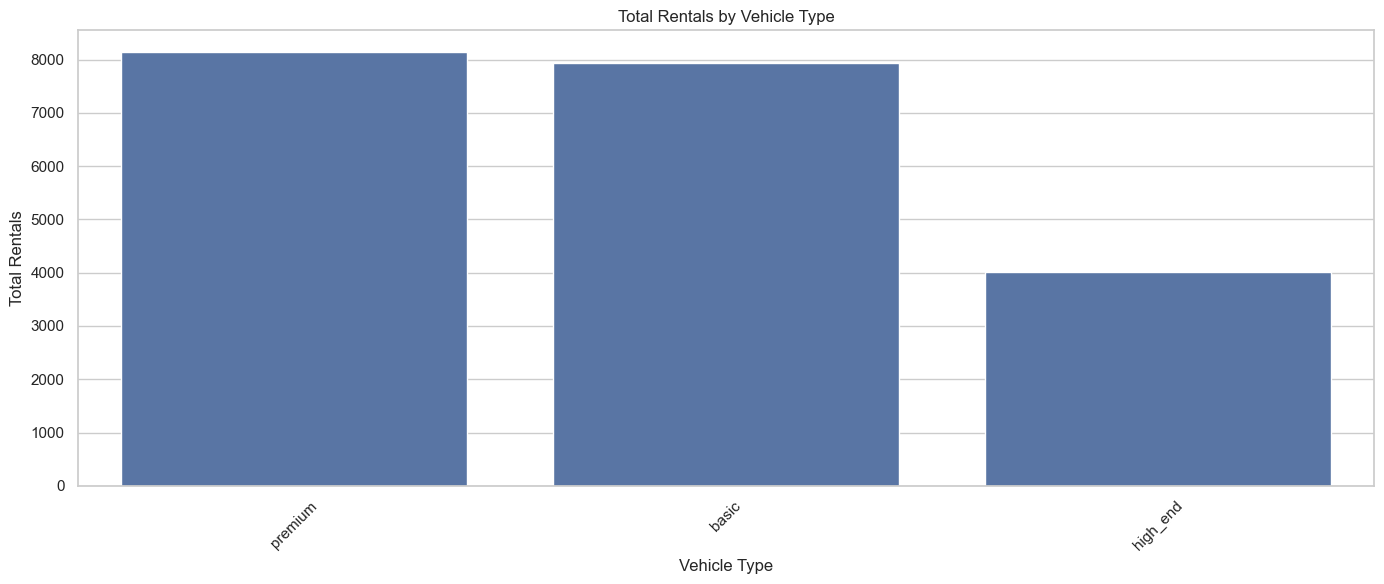

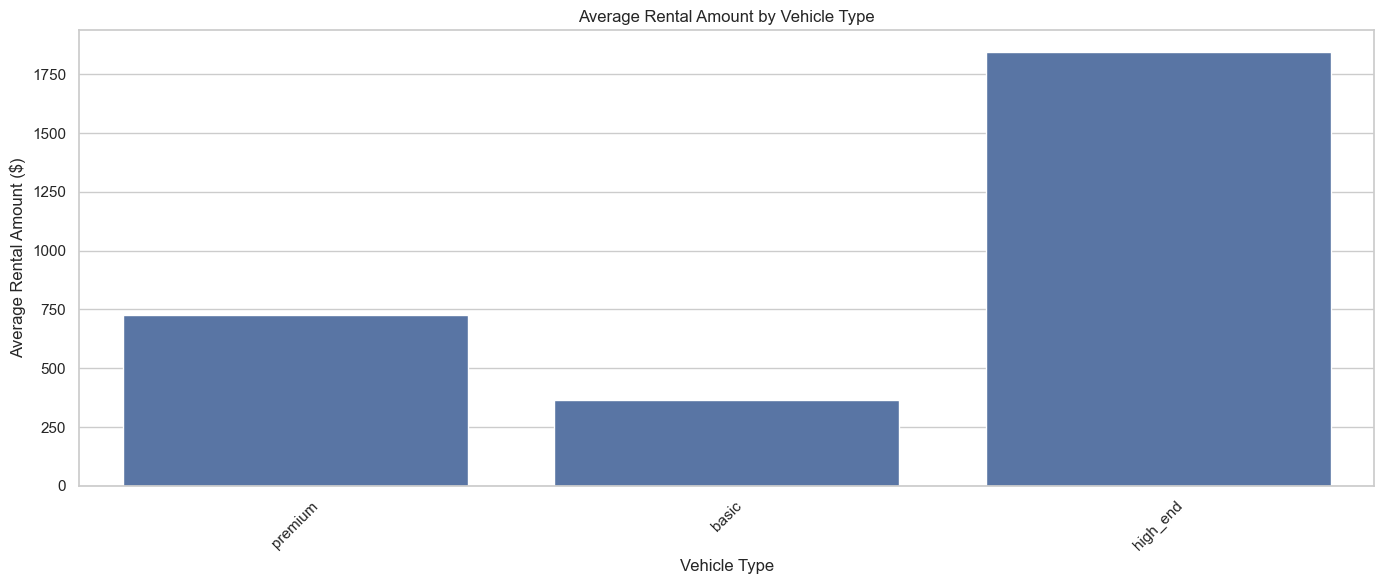

In [12]:
# Visualize vehicle type rentals
plt.figure(figsize=(14, 6))
sns.barplot(x="vehicle_type", y="total_rentals", data=vehicle_type_rentals)
plt.title("Total Rentals by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Total Rentals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize average rental amount by vehicle type
plt.figure(figsize=(14, 6))
sns.barplot(x="vehicle_type", y="avg_rental_amount", data=vehicle_type_rentals)
plt.title("Average Rental Amount by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Average Rental Amount ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Query 3: Top-Spending Users

In [14]:
query3 = """
SELECT 
    user_id, 
    first_name, 
    last_name, 
    total_spent, 
    total_rentals, 
    avg_rental_amount,
    spending_category
FROM 
    user_metrics
WHERE 
    spending_category = 'Top Spender'
ORDER BY 
    total_spent DESC
LIMIT 20
"""

top_spending_users = run_athena_query(query3, database_name, s3_output)
top_spending_users

Query execution ID: 03dd7ded-c114-4a94-9461-b79d937625d5
Query is QUEUED. Waiting...
Query failed: TABLE_NOT_FOUND: line 10:5: Table 'awsdatacatalog.car_rental_db.user_metrics' does not exist


In [ ]:
# Visualize top spending users
plt.figure(figsize=(14, 6))
sns.barplot(x="user_id", y="total_spent", data=top_spending_users.head(10))
plt.title("Top 10 Spending Users")
plt.xlabel("User ID")
plt.ylabel("Total Spent ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Query 4: Daily Transaction Trends

In [15]:
query4 = """
SELECT 
    rental_date, 
    total_transactions, 
    total_revenue, 
    avg_transaction_amount,
    unique_users
FROM 
    daily_metrics
ORDER BY 
    rental_date
"""

daily_trends = run_athena_query(query4, database_name, s3_output)
daily_trends

Query execution ID: 47dfcf0a-7b7f-4ce1-908d-0fe319441394
Query is QUEUED. Waiting...
Query failed: TABLE_NOT_FOUND: line 8:5: Table 'awsdatacatalog.car_rental_db.daily_metrics' does not exist


In [16]:
# Convert rental_date to datetime
daily_trends["rental_date"] = pd.to_datetime(daily_trends["rental_date"])

# Visualize daily transaction trends
plt.figure(figsize=(14, 6))
plt.plot(
    daily_trends["rental_date"],
    daily_trends["total_transactions"],
    marker="o",
    linestyle="-",
)
plt.title("Daily Transaction Trends")
plt.xlabel("Date")
plt.ylabel("Total Transactions")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize daily revenue trends
plt.figure(figsize=(14, 6))
plt.plot(
    daily_trends["rental_date"],
    daily_trends["total_revenue"],
    marker="o",
    linestyle="-",
    color="green",
)
plt.title("Daily Revenue Trends")
plt.xlabel("Date")
plt.ylabel("Total Revenue ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: 'NoneType' object is not subscriptable

## Query 5: Transaction Patterns by Hour of Day

In [17]:
query5 = """
SELECT 
    hour_of_day, 
    total_transactions, 
    total_revenue, 
    avg_transaction_amount
FROM 
    hourly_metrics
ORDER BY 
    hour_of_day
"""

hourly_patterns = run_athena_query(query5, database_name, s3_output)
hourly_patterns

Query execution ID: c514865d-65f8-4bcc-b374-f5ffee5d01ba
Query is QUEUED. Waiting...
Query failed: TABLE_NOT_FOUND: line 7:5: Table 'awsdatacatalog.car_rental_db.hourly_metrics' does not exist


In [ ]:
# Visualize hourly transaction patterns
plt.figure(figsize=(14, 6))
plt.plot(
    hourly_patterns["hour_of_day"],
    hourly_patterns["total_transactions"],
    marker="o",
    linestyle="-",
)
plt.title("Transaction Patterns by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Transactions")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

## Query 6: Transaction Patterns by Day of Week

In [ ]:
query6 = """
SELECT 
    day_of_week, 
    total_transactions, 
    total_revenue, 
    avg_transaction_amount
FROM 
    day_of_week_metrics
ORDER BY 
    day_of_week
"""

day_of_week_patterns = run_athena_query(query6, database_name, s3_output)
day_of_week_patterns

In [ ]:
# Map day_of_week numbers to names
day_names = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday",
}
day_of_week_patterns["day_name"] = day_of_week_patterns["day_of_week"].map(day_names)

# Visualize day of week transaction patterns
plt.figure(figsize=(14, 6))
sns.barplot(x="day_name", y="total_transactions", data=day_of_week_patterns)
plt.title("Transaction Patterns by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Transactions")
plt.tight_layout()
plt.show()

## Query 7: Brand Performance Analysis

In [ ]:
query7 = """
SELECT 
    brand, 
    total_rentals, 
    total_revenue, 
    avg_rental_amount,
    unique_vehicles
FROM 
    brand_metrics
ORDER BY 
    total_revenue DESC
LIMIT 15
"""

brand_performance = run_athena_query(query7, database_name, s3_output)
brand_performance

In [ ]:
# Visualize brand performance by total revenue
plt.figure(figsize=(14, 6))
sns.barplot(x="brand", y="total_revenue", data=brand_performance.head(10))
plt.title("Top 10 Brands by Total Revenue")
plt.xlabel("Brand")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visualize brand performance by average rental amount
plt.figure(figsize=(14, 6))
sns.barplot(x="brand", y="avg_rental_amount", data=brand_performance.head(10))
plt.title("Top 10 Brands by Average Rental Amount")
plt.xlabel("Brand")
plt.ylabel("Average Rental Amount ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Query 8: Location Performance by City

In [ ]:
query8 = """
SELECT 
    city, 
    state, 
    COUNT(*) as num_locations,
    SUM(total_transactions) as total_transactions,
    SUM(total_revenue) as total_revenue,
    AVG(avg_transaction_amount) as avg_transaction_amount
FROM 
    location_metrics
GROUP BY 
    city, state
ORDER BY 
    total_revenue DESC
LIMIT 15
"""

city_performance = run_athena_query(query8, database_name, s3_output)
city_performance

In [ ]:
# Visualize city performance by total revenue
plt.figure(figsize=(14, 6))
sns.barplot(x="city", y="total_revenue", data=city_performance.head(10))
plt.title("Top 10 Cities by Total Revenue")
plt.xlabel("City")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Summary of Insights

Based on the Athena queries and visualizations, here are the key business insights:

1. **Top Revenue-Generating Locations**: Identified the highest-performing rental locations by revenue.
2. **Vehicle Type Performance**: Analyzed which vehicle types are most popular and generate the most revenue.
3. **Top Spending Users**: Identified the most valuable customers based on their spending patterns.
4. **Temporal Patterns**: Discovered trends in rental activity by day, hour, and day of week.
5. **Brand Performance**: Analyzed which car brands are most profitable and popular.
6. **Geographic Insights**: Identified the top-performing cities for car rentals.

These insights can help the car rental marketplace optimize inventory allocation, pricing strategies, marketing campaigns, and expansion plans.